In [ ]:
import matplotlib.pyplot as plt

In [ ]:
START_TIME = 1.0 # in seconds
BW = 100 # in Gbps
CORE_BW = 400 # Gbps
PORT_NO_START = 1000
NUM_HOSTS = 32

BOLT_HDR_SIZE = 26. # Bytes
IP_HDR_SIZE = 20.   # Bytes
MTU = 5000.         # Bytes
PKT_PAYLOAD_SIZE = MTU - IP_HDR_SIZE - BOLT_HDR_SIZE

LINK_DELAY = 315 # nanoseconds

receiver_port_to_analyze = 1000

workload = 'Google_RPC_readBatch'
# workload = 'Facebook_Hadoop'
load = 0.8
simIdx = 0

trace_path = 'outputs/bolt-'+str(NUM_HOSTS)+'host-fattree/'
trace_path += workload + '_load-' + str(int(load*100)) + 'p_' + str(simIdx) + '_'
trace_path += 'MSGAGG_'

if BW == 100:
  rate_info = '_100G'
else:
  rate_info = ''

flow_stats_filename = trace_path + 'DEFAULT' + rate_info + '.log'
q_log_filename = trace_path + 'DEFAULT' + rate_info + '.qlen'

In [ ]:
def readQueueLog(filename, num_hosts):
  times = [[] for i in range(num_hosts)]
  q_sizes = [[] for i in range(num_hosts)]
  with open(filename, 'r') as f:
    for line in f:
      queue_log = line.split()
      try:
        time = float(queue_log[0])*1e-9 - START_TIME # in seconds
        host = int(queue_log[1])
        q_size = float(queue_log[2]) * 8.0 / BW * 1e-3 # in usec
      except:
        continue

      times[host].append(time)
      q_sizes[host].append(q_size)

  retval = {}
  retval['times'] = times
  retval['q_sizes'] = q_sizes
  return retval

In [ ]:
flow_stats = {}
with open(flow_stats_filename, 'r') as f:
  for line in f:
    flow_stat_log = line.split()

    receiver = flow_stat_log[2]
    if (int(receiver.split(':')[1]) != receiver_port_to_analyze):
      continue

    time = float(flow_stat_log[0])*1e-9 - START_TIME # in seconds
    sender = flow_stat_log[1]
    cwnd = float(flow_stat_log[4]) # in bytes
    rtt = float(flow_stat_log[5]) * 1e-3 # in usec

    if (rtt != 0):
      rate = cwnd * 8.0 / rtt * 1e-3 # in Gbps
    elif (cwnd != 0):
      rate = BW

    if sender in flow_stats.keys():
      flow_stats[sender]['times'].append(time)
      flow_stats[sender]['rates'].append(rate)
      flow_stats[sender]['cwnds'].append(cwnd)
      flow_stats[sender]['rtts'].append(rtt)
    else:
      flow_stats[sender] = {}
      flow_stats[sender]['times'] = [time]
      flow_stats[sender]['rates'] = [rate]
      flow_stats[sender]['cwnds'] = [cwnd]
      flow_stats[sender]['rtts'] = [rtt]

In [ ]:
q_log = readQueueLog(q_log_filename, NUM_HOSTS)

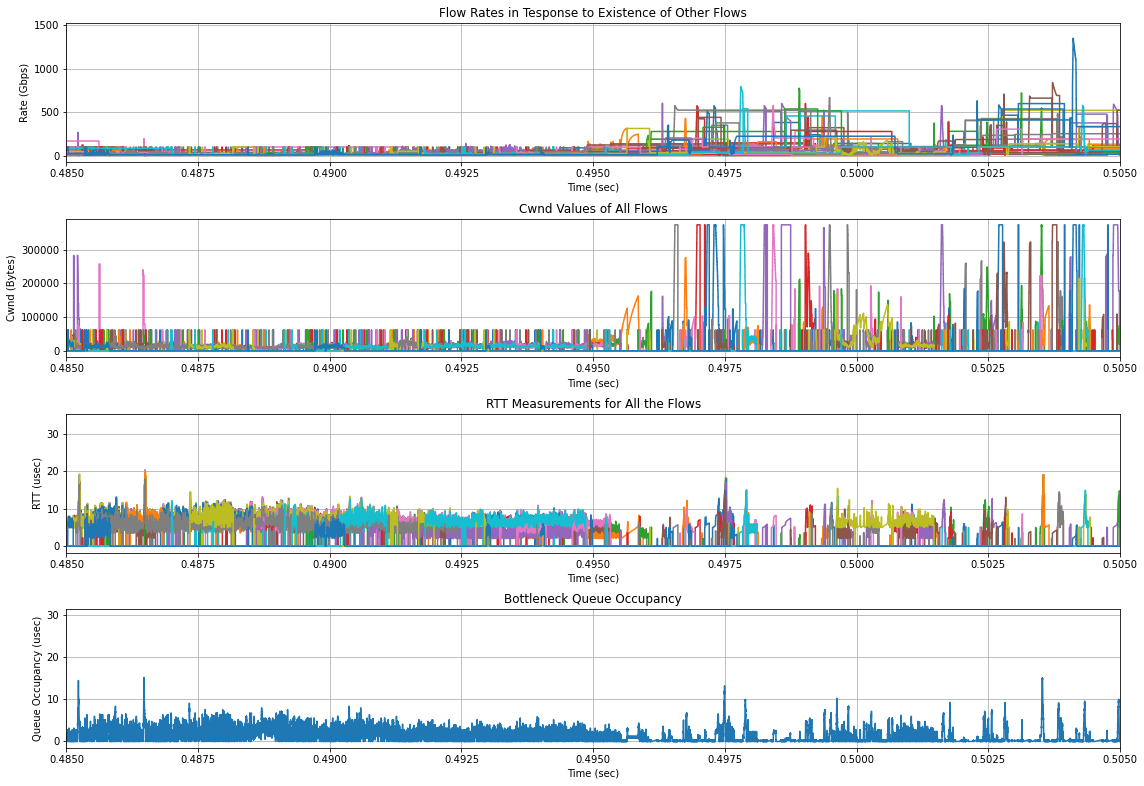

In [ ]:
plt.figure(figsize=(16,11))
xlim = [0.485,0.505]

plt.subplot(4,1,1)
for sender, stats in flow_stats.items():
  plt.step(stats['times'],stats['rates'],label=sender, where='post')

# plt.ylim([0,20])
if xlim is not None:
  plt.xlim(xlim)

# plt.legend()
plt.grid()
plt.title('Flow Rates in Tesponse to Existence of Other Flows')
plt.xlabel('Time (sec)')
plt.ylabel('Rate (Gbps)')
plt.tight_layout()

plt.subplot(4,1,2)
for sender, stats in flow_stats.items():
  plt.step(stats['times'],stats['cwnds'],label=sender, where='post')

# plt.ylim([0,30000])
if xlim is not None:
  plt.xlim(xlim)

# plt.legend()
plt.grid()
plt.title('Cwnd Values of All Flows')
plt.xlabel('Time (sec)')
plt.ylabel('Cwnd (Bytes)')
plt.tight_layout()

plt.subplot(4,1,3)
for sender, stats in flow_stats.items():
  plt.step(stats['times'],stats['rtts'],label=sender, where='post')

# # plt.ylim([80,105])
if xlim is not None:
  plt.xlim(xlim)

# plt.legend()
plt.grid()
plt.title('RTT Measurements for All the Flows')
plt.xlabel('Time (sec)')
plt.ylabel('RTT (usec)')
plt.tight_layout()

plt.subplot(4,1,4)
plt.plot(q_log['times'][receiver_port_to_analyze - PORT_NO_START], 
         q_log['q_sizes'][receiver_port_to_analyze - PORT_NO_START])

if xlim is not None:
  plt.xlim(xlim)

plt.title('Bottleneck Queue Occupancy')
plt.xlabel('Time (sec)')
plt.ylabel('Queue Occupancy (usec)')
plt.grid()
plt.tight_layout()

plt.show()

In [ ]:
# Calculate the expected RTT and BDP in this network
ds1 = MTU * 8 / BW # in ns
cs1 = (IP_HDR_SIZE + BOLT_HDR_SIZE) * 8 / BW # in ns
rtt1 = 4 * LINK_DELAY + 2 * ds1 + 2 * cs1

ds2 = MTU * 8 / CORE_BW # in ns
cs2 = (IP_HDR_SIZE + BOLT_HDR_SIZE) * 8 / CORE_BW # in ns
rtt2 = rtt1 + 4 * LINK_DELAY + 2 * ds2 + 2 * cs2

rtt3 = rtt2 + 4 * LINK_DELAY + 2 * ds2 + 2 * cs2

print('RTTs: ',rtt1, rtt2, rtt3)

rttE = 7/32 * rtt1 + 8/32 * rtt2 + 16/32 * rtt3
print('RTTe: ', rttE)

bdpE = BW * rttE / 8
print('BDPe: ', bdpE)

RTTs:  2067.36 3529.2000000000003 4991.040000000001
RTTe:  3830.0550000000003
BDPe:  47875.6875
